In [19]:
import torch
import dgl
import time
import random
import os

from rdkit import Chem
from rdkit.Chem import Draw
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from affinity_module.config import get_config

from dgl import DGLGraph
from dgllife.model.gnn import *
import numpy as np
import pandas as pd

from dgllife.model.gnn.gat import GAT
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgllife.utils import EarlyStopping, Meter, RandomSplitter
from dgllife.data import PDBBind, MoleculeCSVDataset
from dgllife.model.model_zoo import GATPredictor

from affinity_module.utils import set_random_seed, collate_molgraphs, AffinityDataset, load_model, run_a_train_epoch, run_an_eval_epoch, run_visualization_epoch

torch.cuda.empty_cache()

In [2]:
args = dict()
args.update(get_config('v1'))
# args['device'] = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
args['device'] = torch.device("cpu")
set_random_seed(args['random_seed'])

dataset = AffinityDataset(
                 smiles_to_graph=smiles_to_bigraph,
                 smiles_node_featurizer=CanonicalAtomFeaturizer(),
                 smiles_edge_featurizer=CanonicalBondFeaturizer(),
                 load=True)

train_set, val_set, test_set = RandomSplitter.train_val_test_split(
        dataset, frac_train=args['frac_train'], frac_val=args['frac_val'],
        frac_test=args['frac_test'], random_state=args['random_seed'])

# test_loader = DataLoader(dataset=test_set,
#                          batch_size=args['batch_size'],
#                          collate_fn=collate_molgraphs)
viz_loader = DataLoader(dataset=test_set,
                         batch_size=1,
                         collate_fn=collate_molgraphs)
model = load_model(args)
#     loss_fn = nn.MSELoss(reduction='none')
loss_fn = nn.L1Loss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'],
                             weight_decay=args['weight_decay'])
stopper = EarlyStopping(mode=args['mode'],
                        patience=args['patience'],
                        filename='smiles-2-layers-fasta-32-32-MAE-0.675.pth')
print('Loading checkpoint...')
stopper.load_checkpoint(model)
model.to(args['device'])

Loading previously saved dgl graphs...
smiles: 351527
fasta: 351527
smiles_graphs: 351527
fasta_graphs: 351527
labels: 351527
Loading checkpoint...


mhGANN(
  (smiles_gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=74, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=86, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0, inplace=False)
        (1): Linear(in_features=600, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=300, out_features=300, bias=True)
        )
        (gru): GRUCell(300, 300)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=600, out_features=1, bias

In [141]:
index = 4
smiles, smiles_node_weights, fasta, fasta_node_weights, labels, score = run_visualization_epoch(args, model, viz_loader, index)

# SMILES

In [136]:
smiles[0]

'COc1ccc2c(c1)oc(C)c(N1C(=O)c3ccccc3C1=O)c2=O'

In [122]:
len(smiles[0])

49

In [123]:
len(smiles_node_weights[0])

28

In [118]:
smiles_node_weights[0]

tensor([[0.0400],
        [0.0194],
        [0.0382],
        [0.0014],
        [0.0400],
        [0.0834],
        [0.0064],
        [0.1479],
        [0.0011],
        [0.0021],
        [0.3286],
        [0.0834],
        [0.0021],
        [0.0457],
        [0.0224],
        [0.0382],
        [0.0098],
        [0.0031],
        [0.0041],
        [0.0224],
        [0.0014],
        [0.0128],
        [0.0171],
        [0.0007],
        [0.0046],
        [0.0171],
        [0.0037],
        [0.0028]])

In [124]:
max(smiles_node_weights[0])

tensor([1.])

In [142]:
smiles_node_weights[0] = smiles_node_weights[0] / max(smiles_node_weights[0])

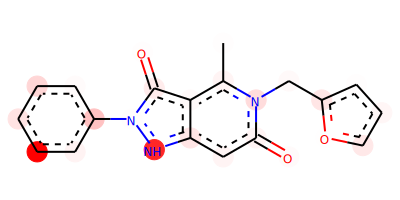

In [143]:
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

mol = Chem.MolFromSmiles(smiles[0])
Compute2DCoords(mol)
atoms = range(smiles_node_weights[0].size()[0])
colors = {i: (1,1-float(smiles_node_weights[0][i]),1-float(smiles_node_weights[0][i])) for i in range(smiles_node_weights[0].size()[0])}
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol,
                highlightBonds=[],
                highlightAtoms=atoms,
                highlightAtomColors=colors)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

In [144]:
smiles_node_weights[1] = smiles_node_weights[1] / max(smiles_node_weights[1])

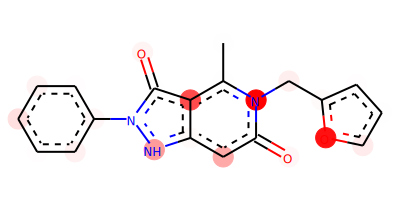

In [145]:
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

mol = Chem.MolFromSmiles(smiles[0])
Compute2DCoords(mol)
atoms = range(smiles_node_weights[1].size()[0])
colors = {i: (1,1-float(smiles_node_weights[1][i]),1-float(smiles_node_weights[1][i])) for i in range(smiles_node_weights[1].size()[0])}
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol,
                highlightBonds=[],
                highlightAtoms=atoms,
                highlightAtomColors=colors)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

# FASTA

In [10]:
fasta

['MKSILDGLADTTFRTITTDLLYVGSNDIQYEDIKGDMASKLGYFPQKFPLTSFRGSPFQEKMTAGDNPQLVPADQVNITEFYNKSLSSFKENEENIQCGENFMDIECFMVLNPSQQLAIAVLSLTLGTFTVLENLLVLCVILHSRSLRCRPSYHFIGSLAVADLLGSVIFVYSFIDFHVFHRKDSRNVFLFKLGGVTASFTASVGSLFLTAIDRYISIHRPLAYKRIVTRPKAVVAFCLMWTIAIVIAVLPLLGWNCEKLQSVCSDIFPHIDETYLMFWIGVTSVLLLFIVYAYMYILWKAHSHAVRMIQRGTQKSIIIHTSEDGKVQVTRPDQARMDIRLAKTLVLILVVLIICWGPLLAIMVYDVFGKMNKLIKTVFAFCSMLCLLNSTVNPIIYALRSKDLRHAFRSMFPSCEGTAQPLDNSMGDSDCLHKHANNAASVHRAAESCIKSTVKIAKVTMSVSTDTSAEAL']

In [17]:
fasta_node_weights.size()

torch.Size([1, 64])